# Machine learning su aplicación en Biología

__Análisis de datos biológicos utilizando métodos de machine learning__

_MeIA_

`2023`

# Proyectos

El primer paso de un proyecto es es la recuperación de los datos y la selección de las características apropiadas. En este ejemplo usaremos secuencias de proteínas codificadas por genes para entrenar los modelos y descubrir su asociación con transtornos relacionados con la edad. 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [6]:
dataset = pd.read_excel('Datos/Genes_dataset.xlsx')
dataset.head()

,Gene_Symbol,Uniprot_ID,Polar,Neutral,Hydrophobicity,0-2.78,2.95-4.0,4.03-8.08,4.9-6.2,8.0-9.2,...,>1.1,1.1,0.1,High (9-65 g/100g),Medium (1.14-7.44 g/100g),Low (0.048-0.82,Very flexible,Moderately flexible,Less flexible,Target
0,CER1,O95813,33.75,35.00,31.25,32.50,46.25,21.25,31.25,30.00,...,8.75,47.50,43.75,11.25,47.50,41.25,22.50,32.50,45.00,1
1,LTA,P01374,18.75,46.25,35.00,42.50,37.50,20.00,35.00,40.00,...,10.00,55.00,35.00,12.50,52.50,35.00,13.75,28.75,57.50,1
2,TP53,P04637,32.50,42.50,25.00,52.50,33.75,13.75,25.00,42.50,...,5.00,33.75,61.25,10.00,40.00,50.00,23.75,30.00,46.25,1
3,TYR,P14679,23.75,40.00,36.25,48.75,30.00,21.25,37.50,37.50,...,18.75,48.75,32.50,21.25,48.75,30.00,15.00,45.00,40.00,1
4,ADRB2,P07550,21.25,37.50,41.25,40.00,42.50,17.50,42.50,33.75,...,11.25,48.75,40.00,15.00,60.00,25.00,13.75,33.75,52.50,1


In [7]:
dataset.shape

(658, 75)

Este dataset tiene 659 observaciones y 75 cararacterísticas. Todos estos pueden ser calculados con secuencias de proteínas. Algunas de las características importantes de esto son:
1. Hidrofobicidad
2. Van der Waals normalizado
3. Polaridad
4. Polarizabilidad
5. Carga
6. Accesibilidad de solventes
7. Estructura secundaria
8. Tensión superficial
9. Propensión al punto de acceso de la interfaz proteína-proteína
10. Propensión a la interfase proteína-ADN
11. Propensión a la interfase proteína-ARN
12. Peso molecular
13. Solubilidad en agua
14. Índice de flexibilidad de aminoácidos

La mayoría de las características tienen subgrupos dentro de sí misma, lo que hace que el número total de características sea 74, además la ultima columna son las etiquetas en las que los genes relacionados con la edad se etiquetan como 1 y los genes benignos se etiquetan como 0.

In [8]:
dataset['Target'].value_counts()

1    329
0    329
Name: Target, dtype: int64

El dataset tiene instancias iguales de conjuntos positivos y negativos, por lo que la tasa de exactitud base es del 50%. 

In [9]:
#Ahora separemos las variables dependeintes e independeintes
X = dataset.iloc[:,2:-1].values
y = dataset.iloc[:,-1].values

In [10]:
#Las características se escalan utilizando la clase de preprocesamiento "StandardScaler"
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_norm = sc.fit_transform(X)

#### PCA

Tratemos de usar el PCA para visualizar las instancias de distribución en un espacio bidimensional.


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

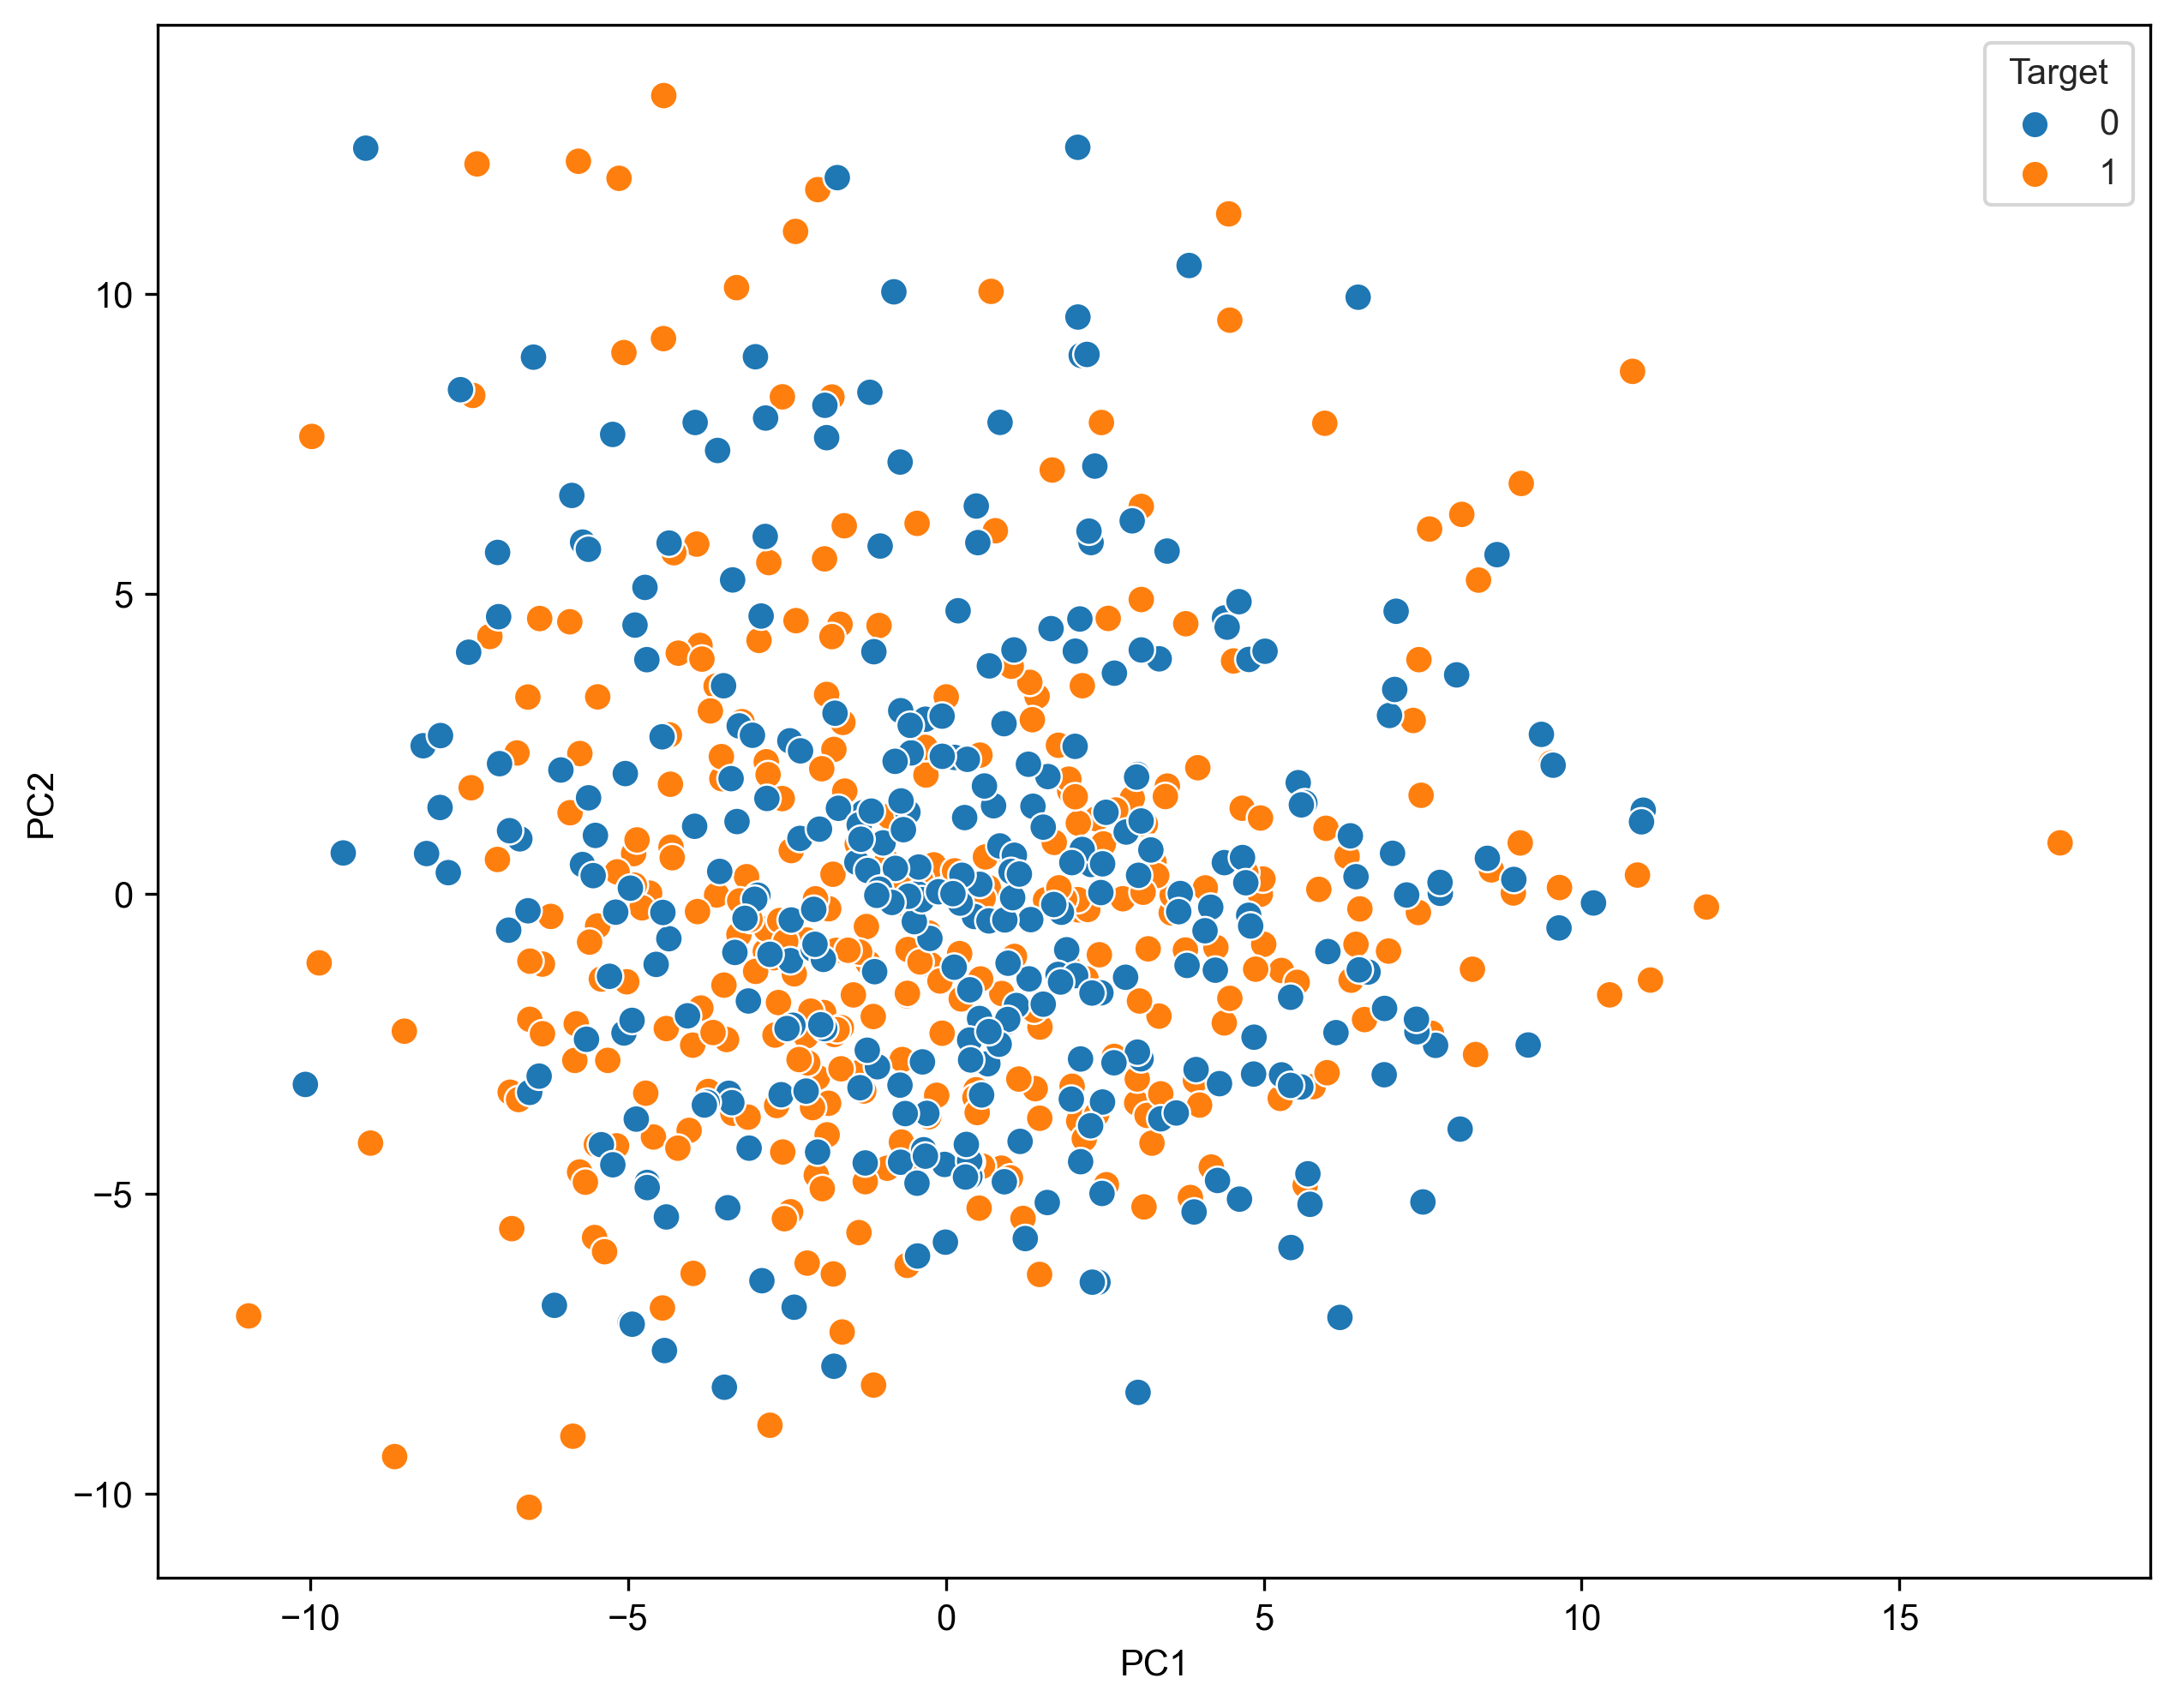

In [12]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=2)
PCs = sklearn_pca.fit_transform(X_norm)
data_transform = pd.DataFrame(PCs,columns=['PC1','PC2'])
data_transform = pd.concat([data_transform,dataset.iloc[:,-1]],axis=1)
fig, axes = plt.subplots(figsize=(10,8))
sns.set_style("whitegrid")
sns.scatterplot(x='PC1',y='PC2',data = data_transform,hue='Target',s=60,
cmap='grey')

Es importante notar que las instancias están bien combinadas según las características de la secuencia en el espacio bidimendional.

#### Ahora dividiremos el dataset en entrenamiento y prueba

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, 
                                                    test_size =0.20, random_state = 101)

Ahora, aplicaremos el conjunto de entrenamiento a los cinco algoritmos de clasificación que hemos revisado hasta ahora y evaluaremos cada uno de ellos usando el conjunto de prueba.

### Entrenamiento del modelo de regresión logística y evaluación

In [19]:
from sklearn.linear_model import LogisticRegression
Logit_classifier = LogisticRegression(random_state = 0)
Logit_classifier.fit(X_train, y_train)
y_pred = Logit_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[33 31]
 [22 46]]


              precision    recall  f1-score   support

           0       0.60      0.52      0.55        64
           1       0.60      0.68      0.63        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.59       132
weighted avg       0.60      0.60      0.60       132



Logramos una exactitud del 60%, que es más que la referencia. Para la clase 1, (es decir los genes relacionados con la edad), además el recall es de 0.68 y el F1-score 0.63.

#### Entrenamiento del modelos K-NN y evaluación
##### Primero eligiremos el valor de K

Text(0, 0.5, 'Error Rate')

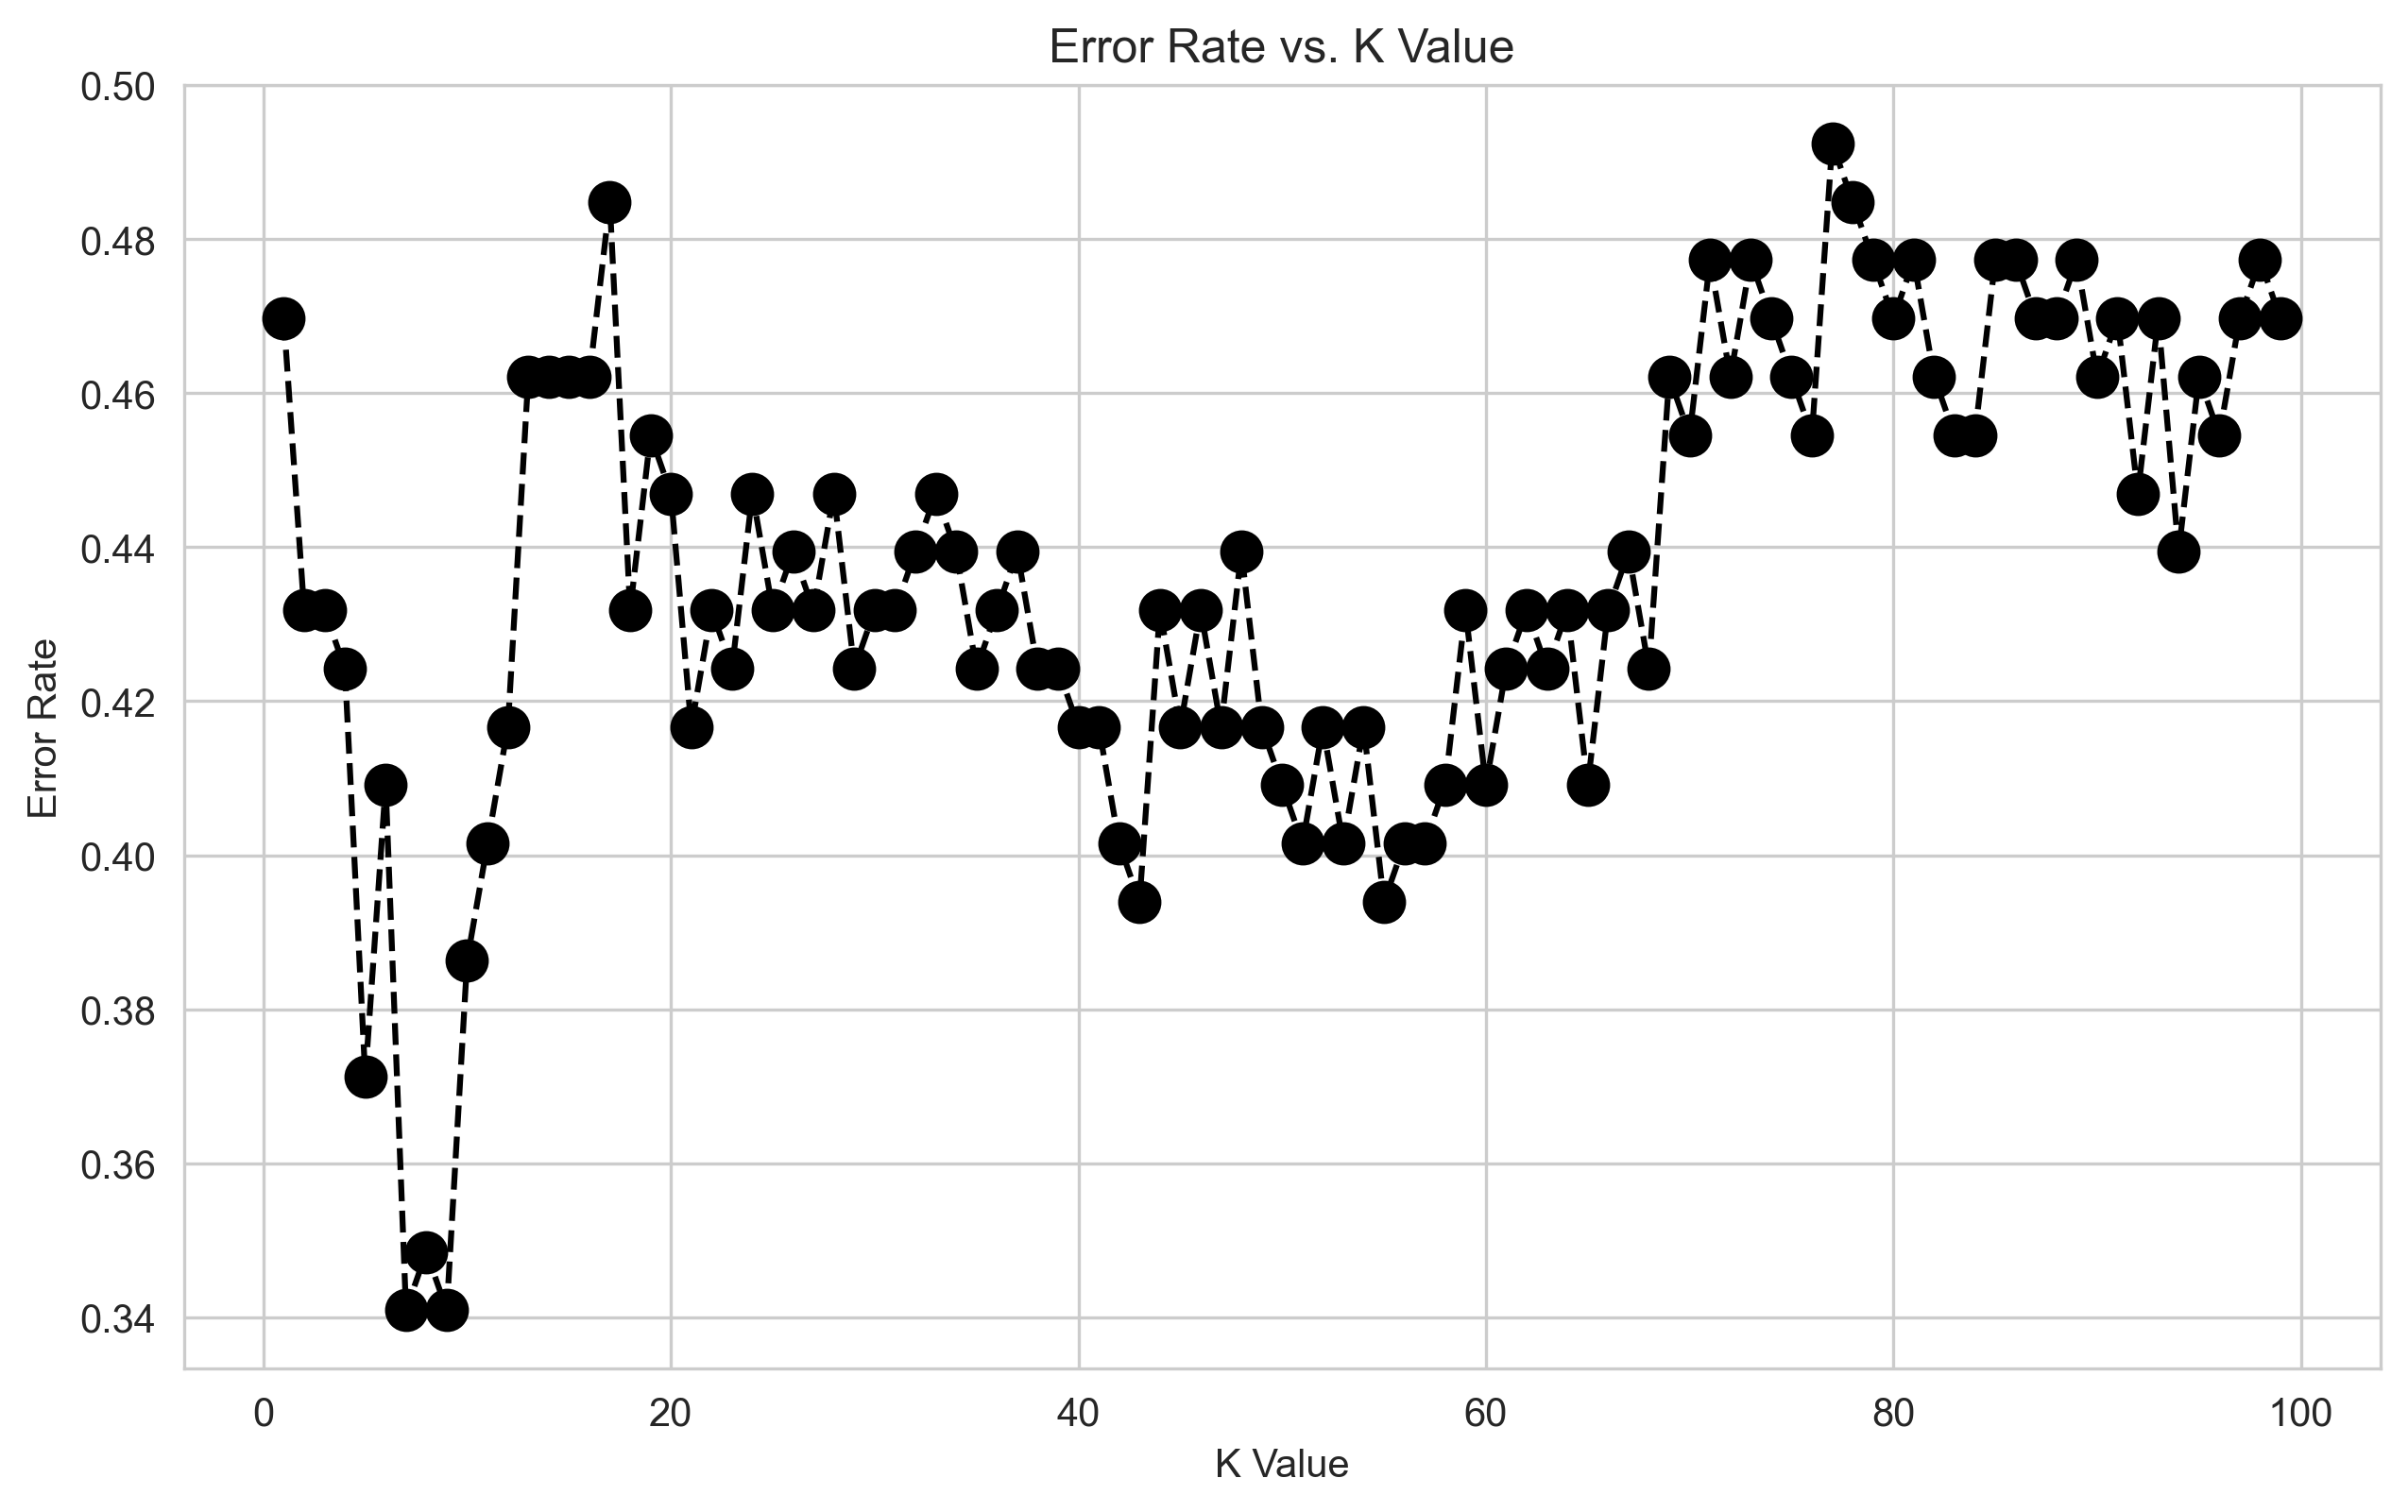

In [21]:
from sklearn.neighbors import KNeighborsClassifier
errors = []


for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    errors.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),errors,color='black', linestyle='dashed', marker='o',
         markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

Podemos observar que el error más bajo esta en k=7 o k=9, vamos a evaluar el modelo usando k=7.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 7)
KNN_classifier.fit(X_train, y_train)
y_pred = KNN_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[43 21]
 [24 44]]


              precision    recall  f1-score   support

           0       0.64      0.67      0.66        64
           1       0.68      0.65      0.66        68

    accuracy                           0.66       132
   macro avg       0.66      0.66      0.66       132
weighted avg       0.66      0.66      0.66       132



K-NN obtiene un exactitud de 66%. 

### Entrenamiento con Random forest y evaluación

Como el rendimiento del modelo depende del número de árboles de decisión generados en un subconjunto aleatorio de datos. Por lo tanto, utilizaremos la técnica de "gread search" con una lista de valores 'n_estimator' para optimizar el número de árboles.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10, 100,150,200,250,300,350,400]}
RF_classifier = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,
verbose=0)
RF_classifier.fit(X_train,y_train)
y_pred = RF_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[38 26]
 [28 40]]


              precision    recall  f1-score   support

           0       0.58      0.59      0.58        64
           1       0.61      0.59      0.60        68

    accuracy                           0.59       132
   macro avg       0.59      0.59      0.59       132
weighted avg       0.59      0.59      0.59       132



El modelo de random forests obtiene un 59% de exactitud, que un poco menor que el modelo K-NN.

### Entrenamiento con SVM y evaluación

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#Aquí tambien utilizaremos la técnica 'grid search' 
#para optimizar el clasificador SVM
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,
0.0001], 'kernel': ['rbf']}

SVM_classifier = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
SVM_classifier.fit(X_train,y_train)
y_pred = SVM_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))


[[37 27]
 [28 40]]


              precision    recall  f1-score   support

           0       0.57      0.58      0.57        64
           1       0.60      0.59      0.59        68

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.58      0.58      0.58       132



SVM tiene una exactitud menor que K-NN y random forest, con 58%.

### Entrenamiento de modelo ANN y evaluación

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()

# 
model = Sequential()
model.add(Dense(units=60,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=15,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          batch_size= 64,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Esta red neuronal tiene dos capas densamente conectadas con 60 y 15 neuronas en cada capa, respectivamente.
La última capa o capa de salida tiene una neurona con una función de activación sigmoidea. Se agregaron capas de abandono entre cada capa para minimizar el riesgo de sobreajuste. El modelo se compila con el optimizador “binary_crossentropyloss” y “rmsprop”. Por último, se entrenó con una función de devolución de llamada de detención temprana para interrumpir el ciclo de entrenamiento una vez que la pérdida de entrenamiento es menor que la pérdida de validación. El modelo dejó de entrenar después de seis épocas. A continuación, evaluamos el modelo en el conjunto de prueba para generar el informe de clasificación.

In [ ]:
predictions = model.predict_classes(X_test)
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

El modelo ANN tiene una exactitud del 56%.
La predicción de genes asociados con un grupo de enfermedades, como las enfermedades relacionadas con la edad, es principalmente un tipo especial de problema de aprendizaje automático llamado aprendizaje positivo no etiquetado (aprendizaje PU) en el que no tenemos un conjunto negativo verdadero bien definido. En el aprendizaje PU, el conjunto positivo está bien definido o es conocido, pero generar un conjunto negativo se basa en el supuesto de que las instancias que no pertenecen al conjunto positivo pueden tratarse como parte de un conjunto negativo. El rendimiento del modelo se mide evaluándolo para predecir un conjunto positivo. De esta forma, el rendimiento de los modelos K-NN y random forest fue mejor en comparación con el resto de modelos. Esto puede deberse al hecho de que estos modelos son capaces de clasificar el conjunto de datos separable de forma no lineal, y estimamos una idea de la no linealidad de los datos del gráfico PCA. Además, la exactitud general se puede aumentar agregando varias características basadas en la ubicación de la red y la celda, como se muestra en (Srivastava et al., 2016), porque los parámetros basados en la secuencia no definen completamente la función de los genes.